In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from IPython.display import display, Audio

import librosa
import librosa.display
import scipy.io.wavfile as wavfile

from numpy.fft import fft, fftfreq

# Read Data & EDA

In [ ]:
sample_rate, data = wavfile.read('/content/exercise.wav')

In [ ]:
print(f"Sample rate (Hz): {sample_rate}")
print(f"Data array shape: {data.shape}")
print(f"Data type: {data.dtype}")

Sample rate (Hz): 11025
Data array shape: (140075,)
Data type: int16


In [ ]:
display(Audio(data, rate=sample_rate))

In [ ]:
x = np.linspace(0, len(data) / sample_rate, len(data))
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=data, mode='lines', name='Original'))
fig.update_layout(title='Audio (Time Domain)', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

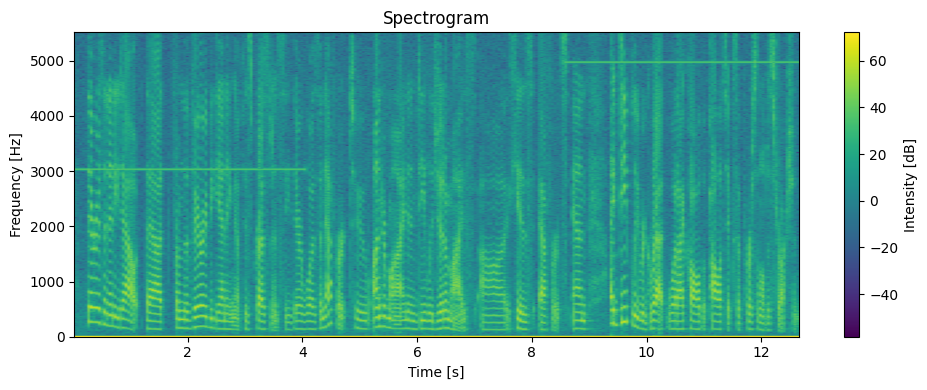

In [ ]:
plt.figure(figsize=(10, 4))
plt.specgram(data, Fs=sample_rate, NFFT=1024, noverlap=512, cmap='viridis')
plt.title('Spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Intensity [dB]')
plt.tight_layout()
plt.show()

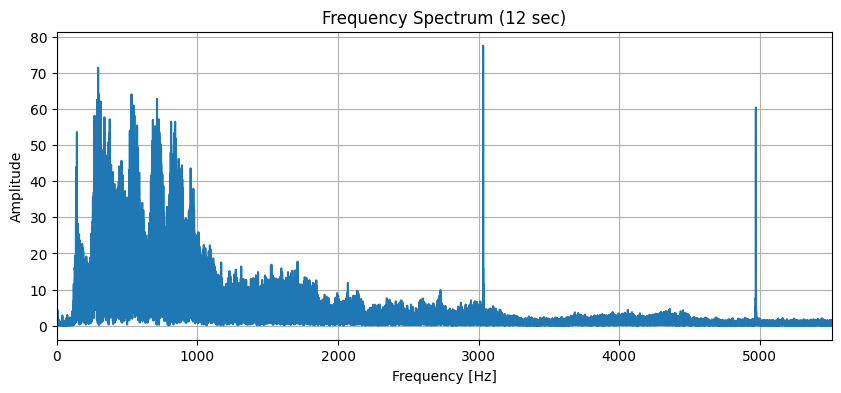

In [ ]:
y = data.astype(float)
start_time = 0  # seconds
end_time = 12    # seconds
duration = end_time - start_time

start_sample = int(sample_rate * start_time)
end_sample = int(sample_rate * end_time)

y_cut = y[start_sample:end_sample]

# Compute FFT
N = len(y_cut)
fft_result = np.fft.fft(y_cut)
fft_freq = np.fft.fftfreq(N, 1/sample_rate)

# Keep only positive frequencies
pos_mask = fft_freq > 0
fft_freq = fft_freq[pos_mask]
fft_magnitude = np.abs(fft_result[pos_mask]) / N

# Plot
plt.figure(figsize=(10, 4))
plt.plot(fft_freq, fft_magnitude)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title(f'Frequency Spectrum ({duration} sec)')
plt.xlim(0, sample_rate/2)
plt.grid(True)
plt.show()

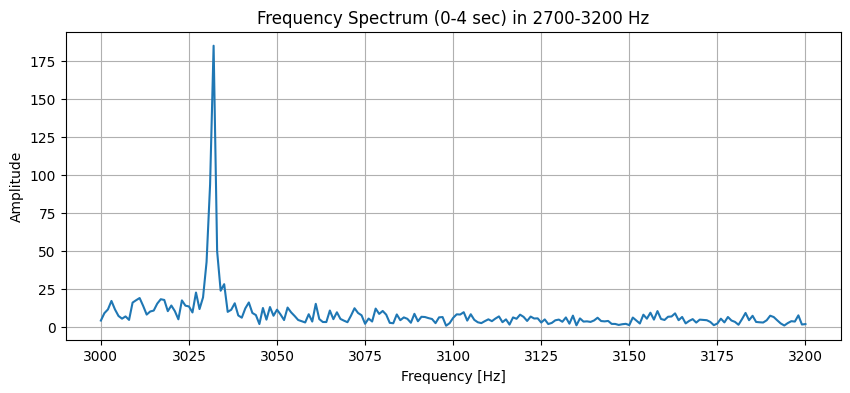

In [ ]:
start_time = 2
end_time = 3
start_sample = int(sample_rate * start_time)
end_sample = int(sample_rate * end_time)
y_cut = y[start_sample:end_sample]

# Compute FFT
N = len(y_cut)
fft_result = np.fft.fft(y_cut)
fft_freq = np.fft.fftfreq(N, 1/sample_rate)

# Keep only positive frequencies
pos_mask = fft_freq > 0
fft_freq = fft_freq[pos_mask]
fft_magnitude = np.abs(fft_result[pos_mask]) / N  # normalize

# Focus on specific zone (2700 - 3200 Hz)
zone_mask = (fft_freq >= 3000) & (fft_freq <= 3200)
fft_zone_freq = fft_freq[zone_mask]
fft_zone_mag = fft_magnitude[zone_mask]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(fft_zone_freq, fft_zone_mag)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title(f'Frequency Spectrum (0-4 sec) in 2700-3200 Hz')
plt.grid(True)
plt.show()

### Plot all zone of noise

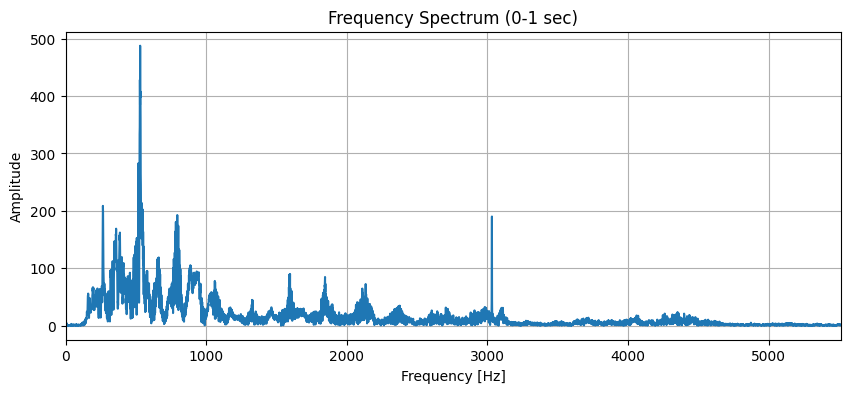

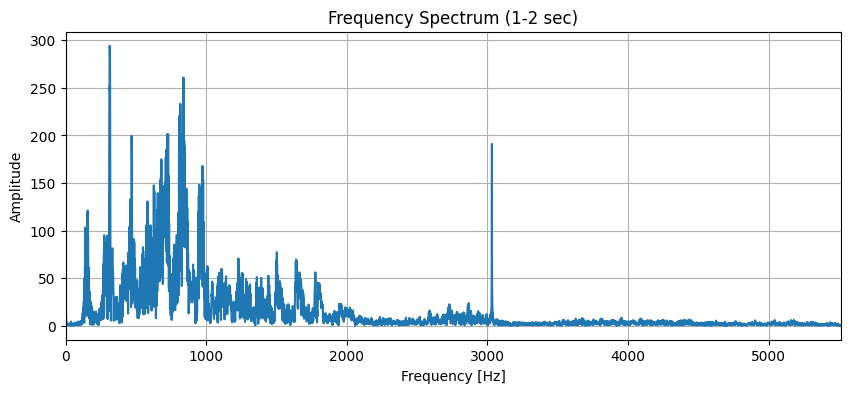

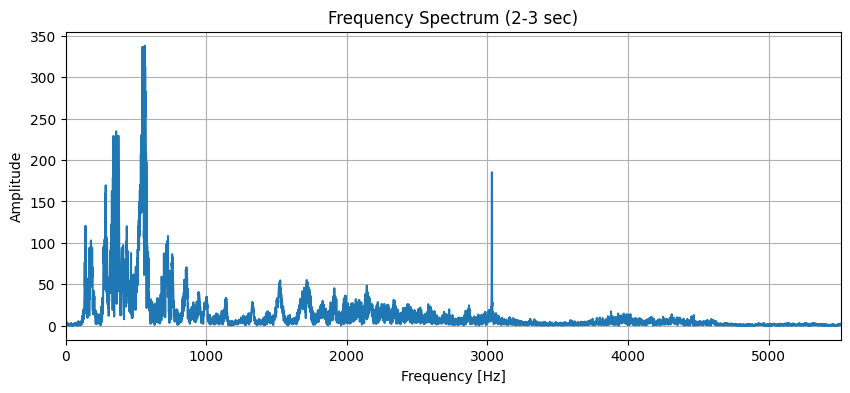

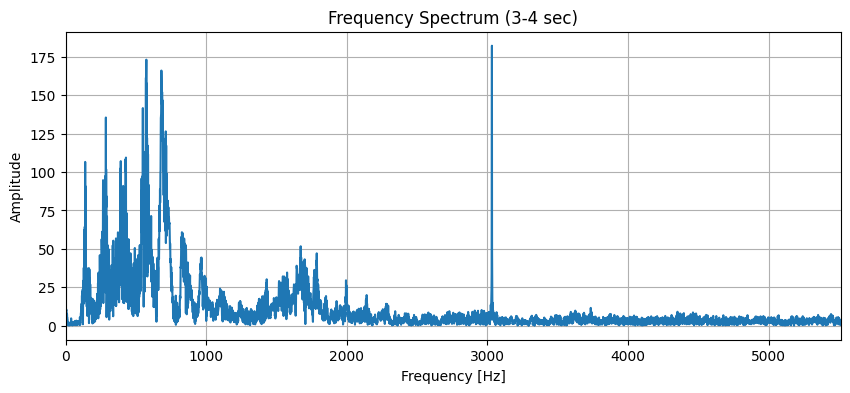

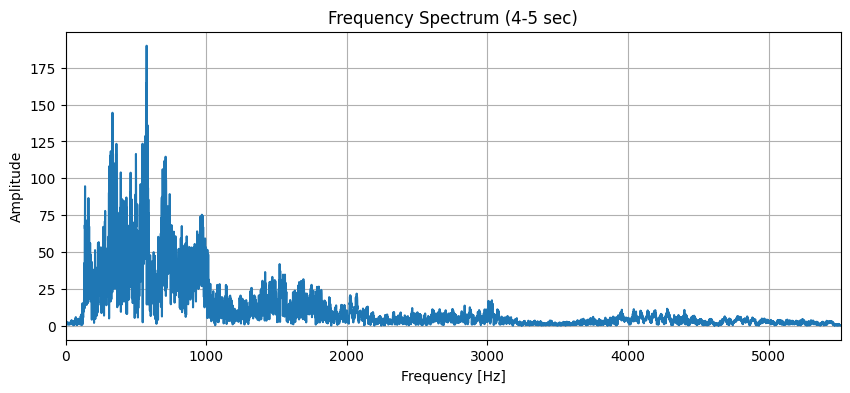

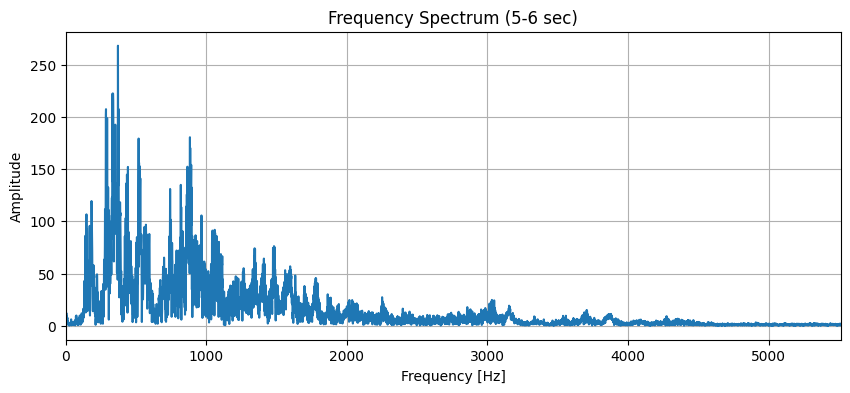

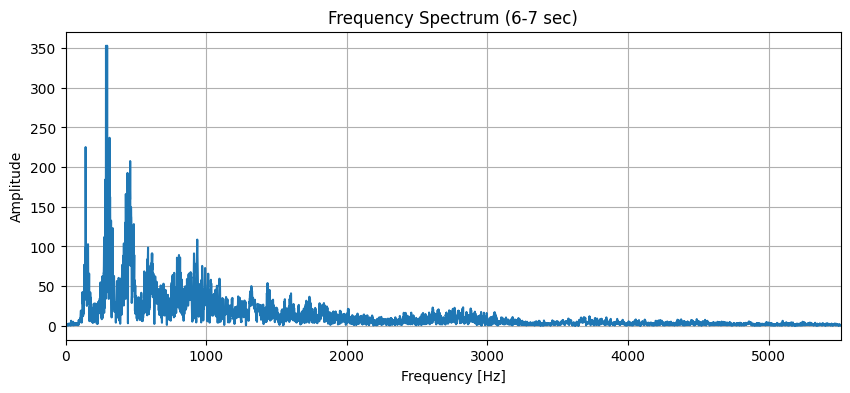

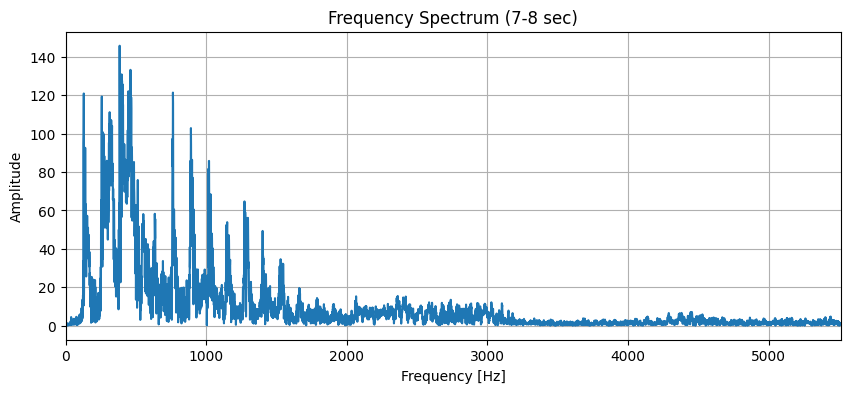

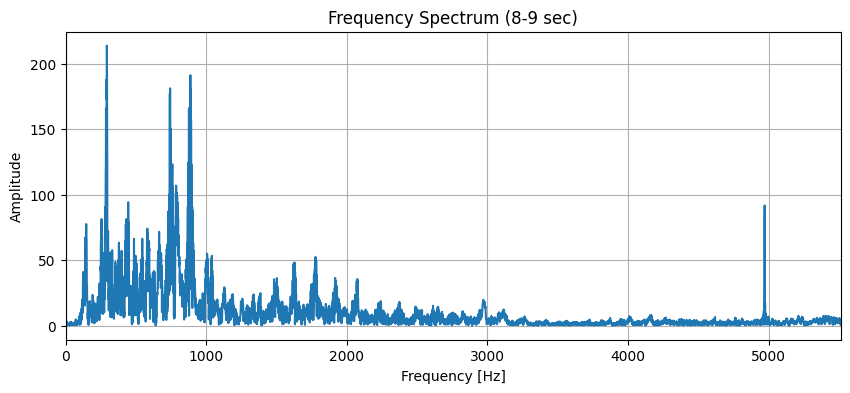

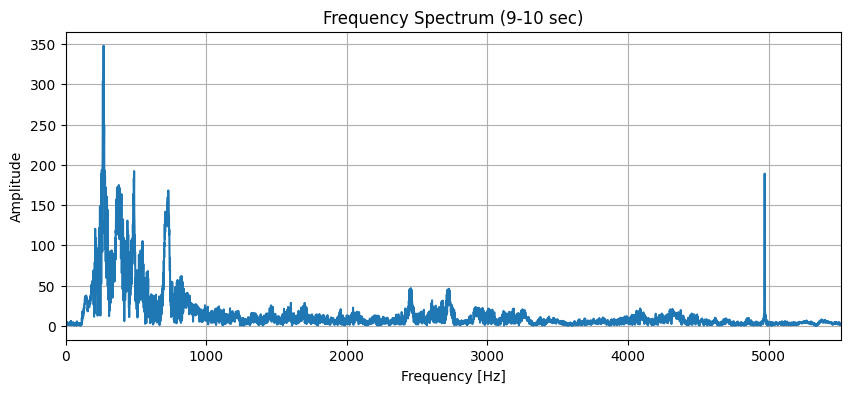

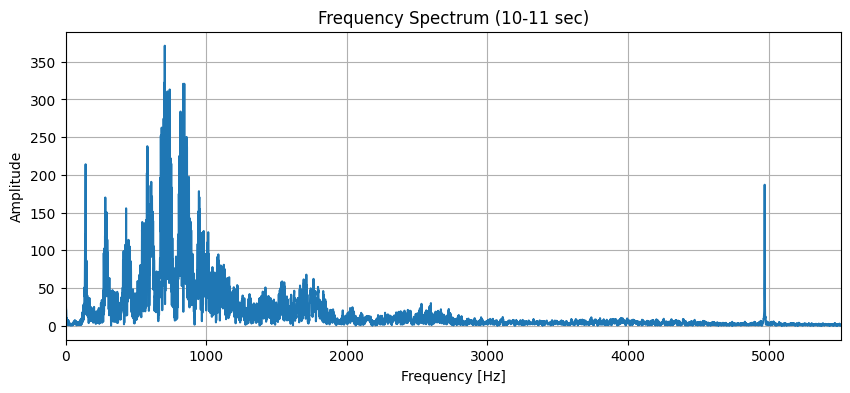

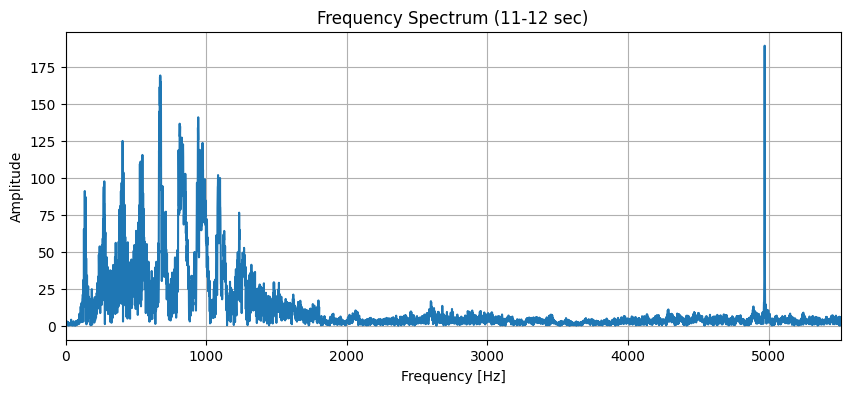

In [ ]:
y = data.astype(float)
total_sec = int(len(y) / sample_rate)  # total duration in seconds

# Loop through each 1-second segment
for start_time in range(total_sec):
    end_time = start_time + 1
    y_cut = y[start_time*sample_rate:end_time*sample_rate]

    # FFT
    N = len(y_cut)
    fft_result = np.fft.fft(y_cut)
    fft_freq = np.fft.fftfreq(N, 1/sample_rate)

    # Only positive frequencies
    pos_mask = fft_freq > 0
    fft_freq_pos = fft_freq[pos_mask]
    fft_mag = np.abs(fft_result[pos_mask]) / N

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(fft_freq_pos, fft_mag)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.title(f'Frequency Spectrum ({start_time}-{end_time} sec)')
    plt.xlim(0, sample_rate/2)
    plt.grid(True)
    plt.show()

### Plot Specific zone of noise

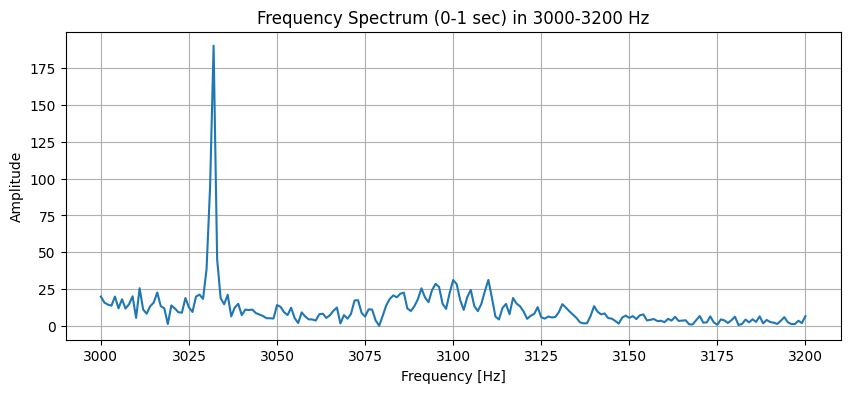

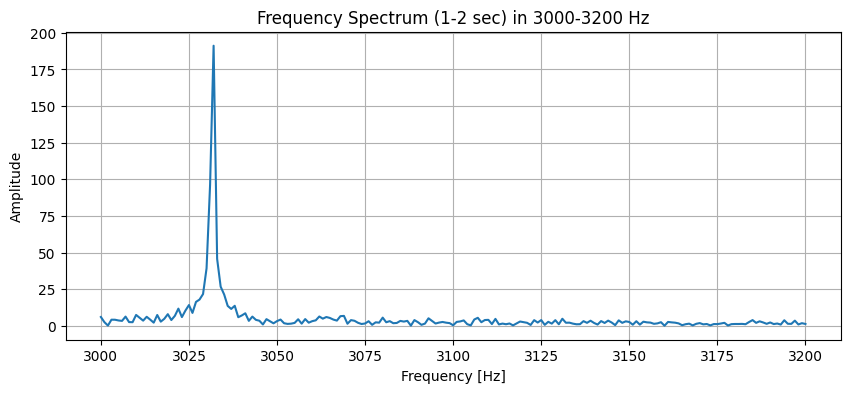

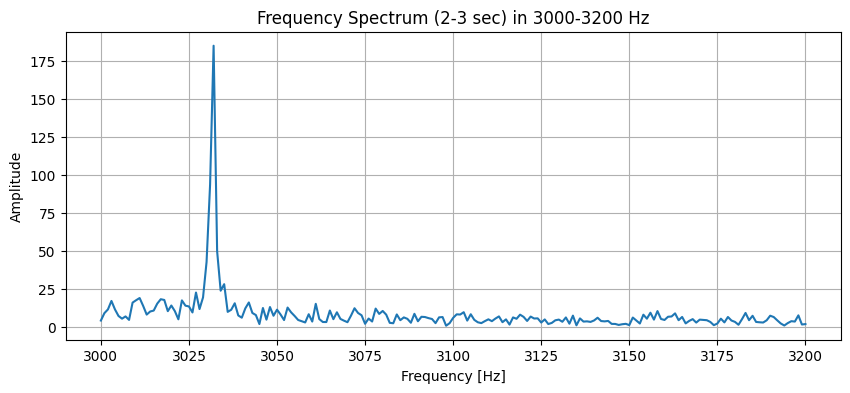

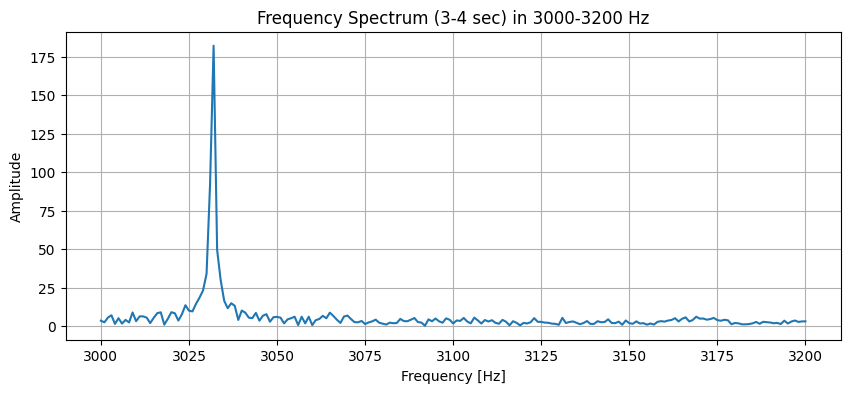

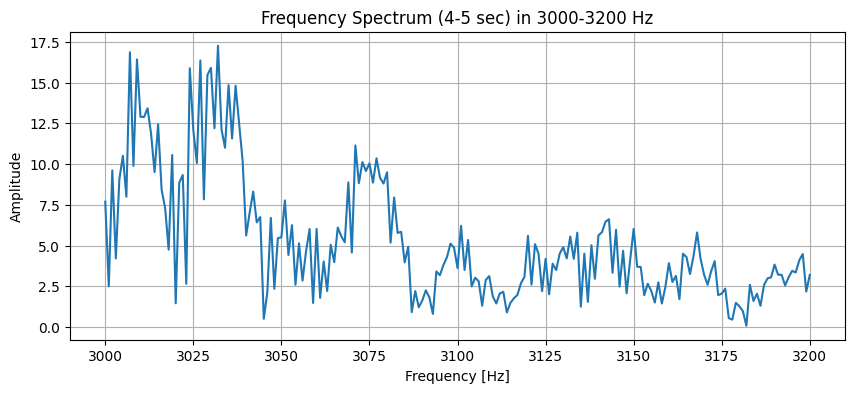

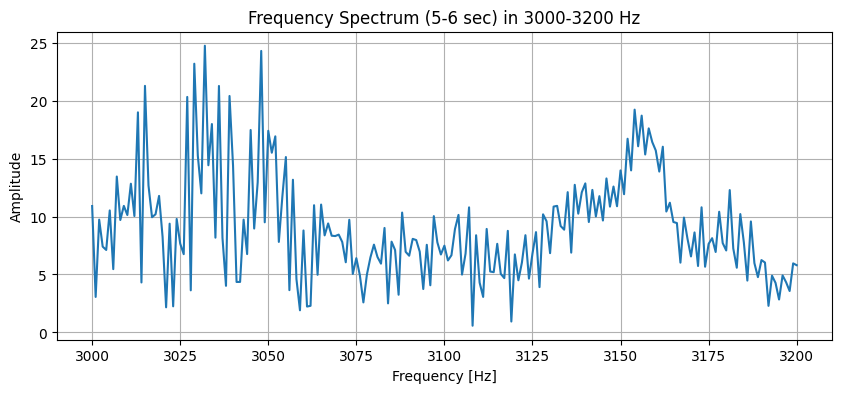

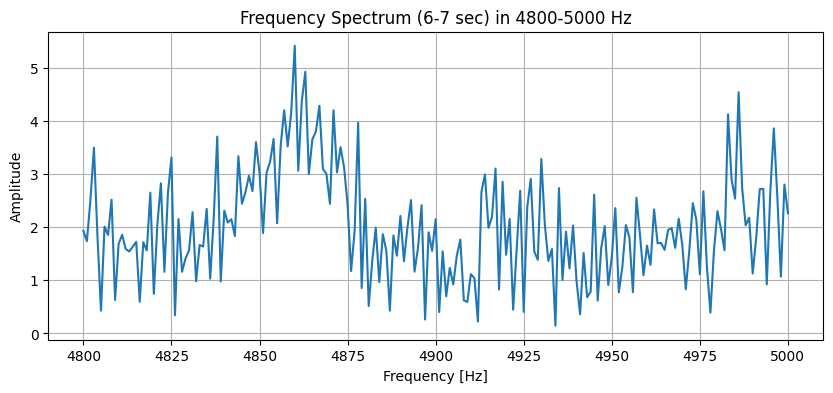

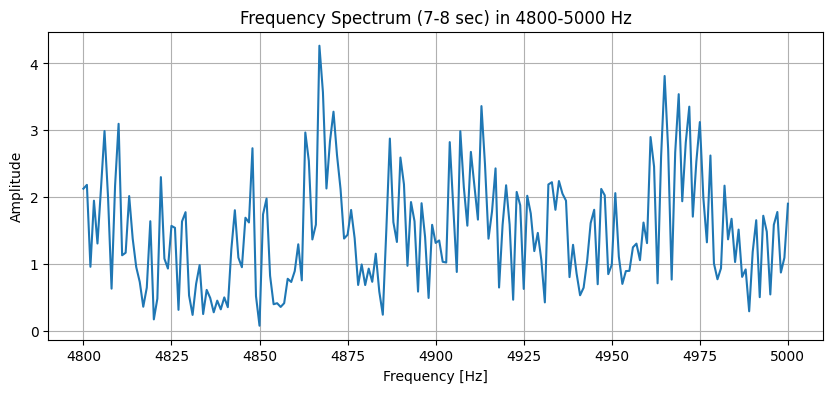

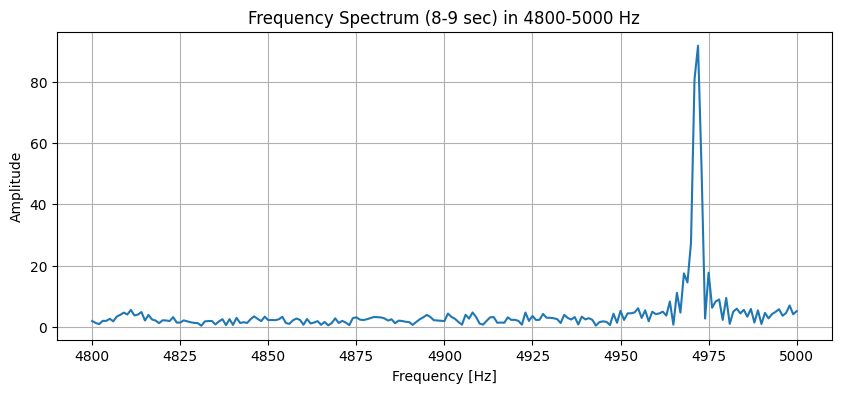

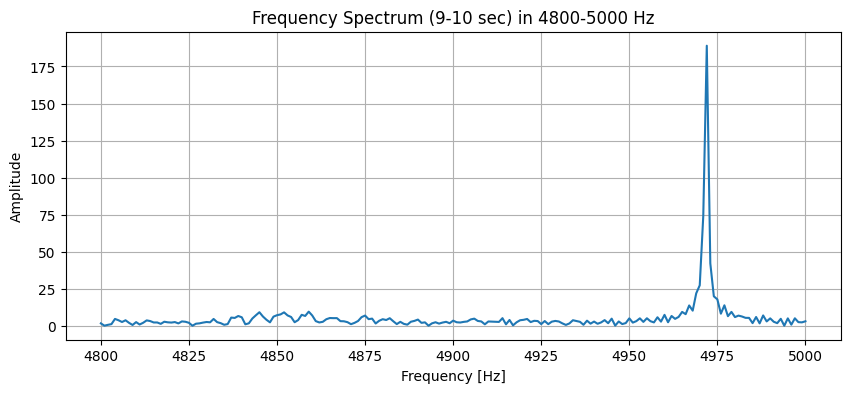

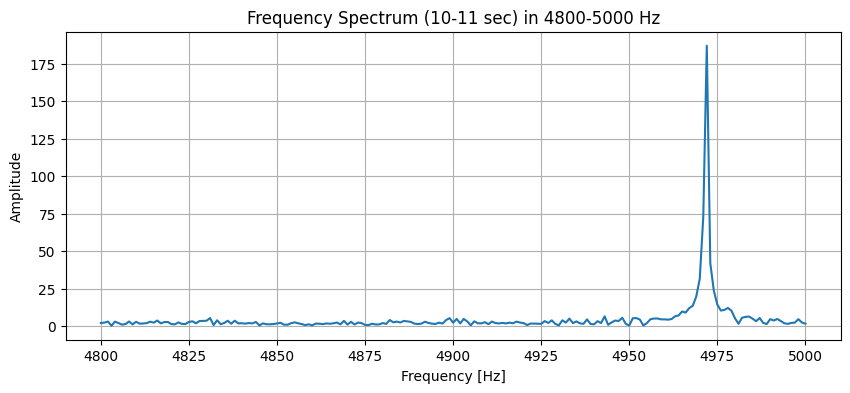

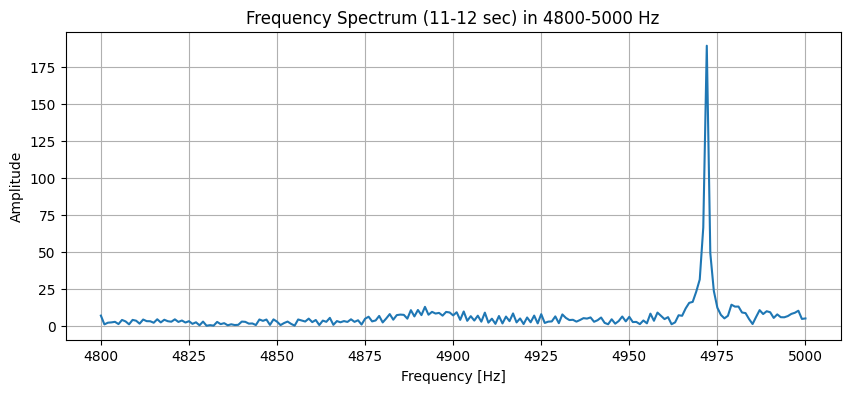

In [ ]:
for start_time in range(total_sec):
    end_time = start_time + 1
    y_cut = y[start_time*sample_rate:end_time*sample_rate]

    # FFT
    N = len(y_cut)
    fft_result = np.fft.fft(y_cut)
    fft_freq = np.fft.fftfreq(N, 1/sample_rate)

    # Only positive frequencies
    pos_mask = fft_freq > 0
    fft_freq_pos = fft_freq[pos_mask]
    fft_mag = np.abs(fft_result[pos_mask]) / N  # normalize

    # Select frequency zone based on start_time
    if start_time < 6:
        f_low, f_high = 3000, 3200
    else:
        f_low, f_high = 4800, 5000

    zone_mask = (fft_freq_pos >= f_low) & (fft_freq_pos <= f_high)
    fft_zone_freq = fft_freq_pos[zone_mask]
    fft_zone_mag = fft_mag[zone_mask]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(fft_zone_freq, fft_zone_mag)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.title(f'Frequency Spectrum ({start_time}-{end_time} sec) in {f_low}-{f_high} Hz')
    plt.grid(True)
    plt.show()

# Create filter

In [ ]:
def noise_reduction_by_segment(y, sr, start_time, end_time, f_low, f_high):
    y_copy = y.copy()

    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    y_seg = y_copy[start_sample:end_sample]

    N = len(y_seg)
    Y = np.fft.fft(y_seg)
    freqs = np.fft.fftfreq(N, 1/sr)

    mask = (np.abs(freqs) >= f_low) & (np.abs(freqs) <= f_high)

    avg_mag = np.mean(np.abs(Y[~mask])) / 16
    Y[mask] = Y[mask] / np.abs(Y[mask]) * avg_mag

    y_copy[start_sample:end_sample] = np.fft.ifft(Y).real
    print(avg_mag)
    return y_copy

In [ ]:
y_clean = noise_reduction_by_segment(y, sample_rate, 0, 1, 3000, 3050)
y_clean = noise_reduction_by_segment(y_clean, sample_rate, 1, 3, 3000, 3050)
y_clean = noise_reduction_by_segment(y_clean, sample_rate, 3, 5, 3000, 3050)
y_clean = noise_reduction_by_segment(y_clean, sample_rate, 8, 9, 4950, 5000)
y_clean = noise_reduction_by_segment(y_clean, sample_rate, 9, 11, 4950, 5000)
y_clean = noise_reduction_by_segment(y_clean, sample_rate, 11, len(y)/sample_rate, 4960, 5000)

13672.509939173857
16879.846200646407
12177.276674311823
8281.895936253477
19146.26314610822
11265.000512393995


In [ ]:
y_clean

array([16510.23298035, 16151.35681963, 15810.60504785, ...,
       16336.22687698, 16143.19075093, 16431.62557565])

In [ ]:
# y_clean[:3000] = 0

In [ ]:
display(Audio(y_clean, rate=sample_rate))

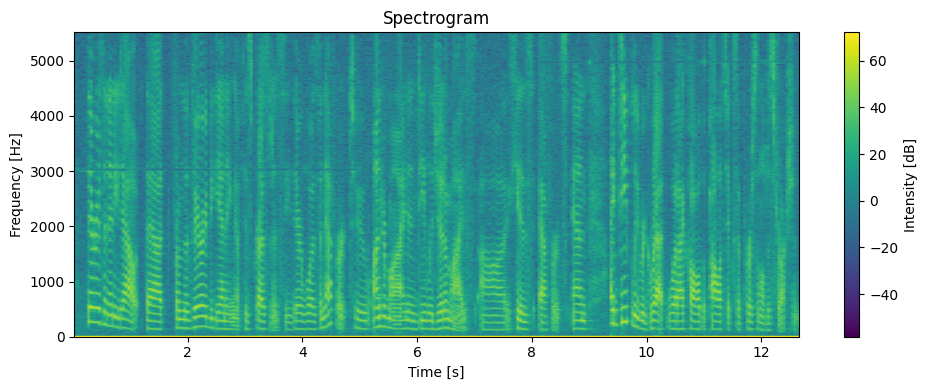

In [ ]:
plt.figure(figsize=(10, 4))
plt.specgram(y_clean, Fs=sample_rate, NFFT=1024, noverlap=512, cmap='viridis')
plt.title('Spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Intensity [dB]')
plt.tight_layout()
plt.show()

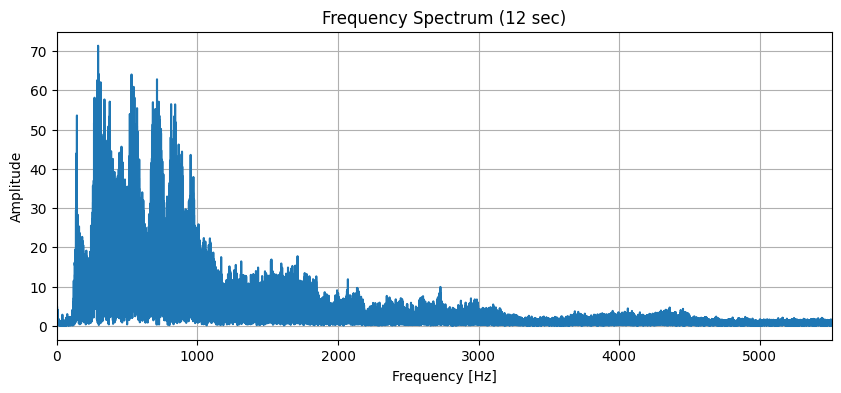

In [ ]:
y = y_clean.astype(float)
start_time = 0  # seconds
end_time = 12    # seconds
duration = end_time - start_time

start_sample = int(sample_rate * start_time)
end_sample = int(sample_rate * end_time)

y_cut = y[start_sample:end_sample]

# Compute FFT
N = len(y_cut)
fft_result = np.fft.fft(y_cut)
fft_freq = np.fft.fftfreq(N, 1/sample_rate)

# Keep only positive frequencies
pos_mask = fft_freq > 0
fft_freq = fft_freq[pos_mask]
fft_magnitude = np.abs(fft_result[pos_mask]) / N

# Plot
plt.figure(figsize=(10, 4))
plt.plot(fft_freq, fft_magnitude)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title(f'Frequency Spectrum ({duration} sec)')
plt.xlim(0, sample_rate/2)
plt.grid(True)
plt.show()

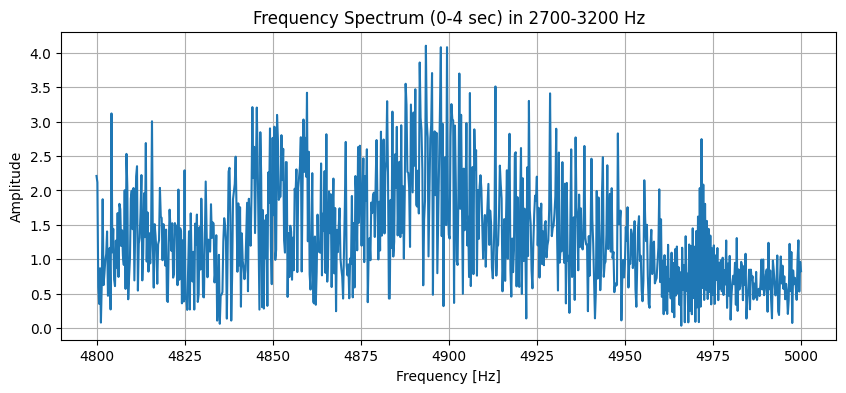

In [ ]:
start_time = 8
end_time = 12
start_sample = int(sample_rate * start_time)
end_sample = int(sample_rate * end_time)
y_cut = y[start_sample:end_sample]

# Compute FFT
N = len(y_cut)
fft_result = np.fft.fft(y_cut)
fft_freq = np.fft.fftfreq(N, 1/sample_rate)

# Keep only positive frequencies
pos_mask = fft_freq > 0
fft_freq = fft_freq[pos_mask]
fft_magnitude = np.abs(fft_result[pos_mask]) / N  # normalize

# Focus on specific zone (2700 - 3200 Hz)
zone_mask = (fft_freq >= 4800) & (fft_freq <= 5000)
fft_zone_freq = fft_freq[zone_mask]
fft_zone_mag = fft_magnitude[zone_mask]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(fft_zone_freq, fft_zone_mag)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title(f'Frequency Spectrum (0-4 sec) in 2700-3200 Hz')
plt.grid(True)
plt.show()

In [ ]:
wavfile.write('/content/exercise_cleaned.wav', sample_rate, y_clean.astype(np.int16))

### Plot all zone

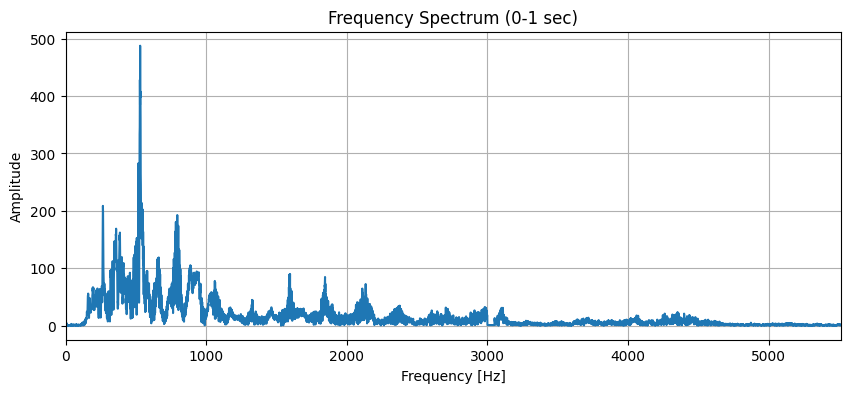

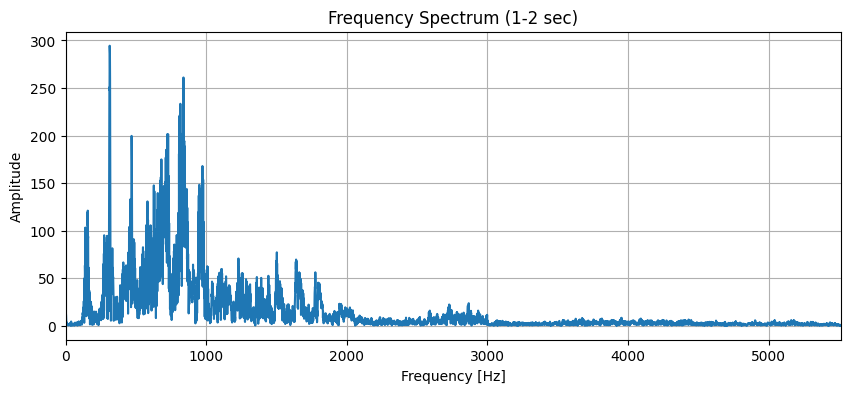

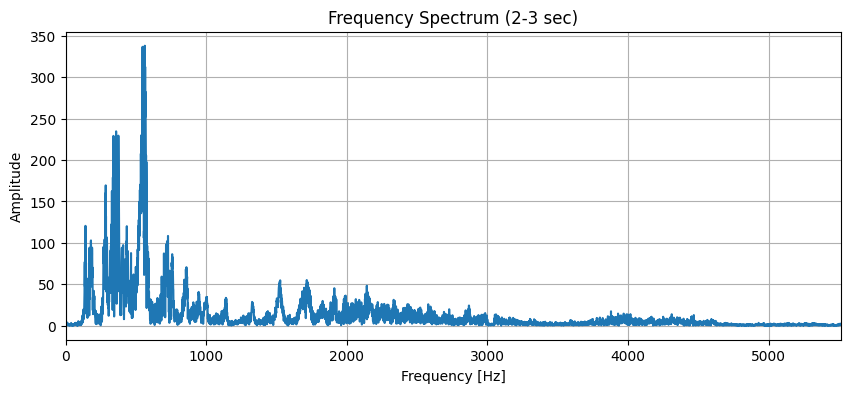

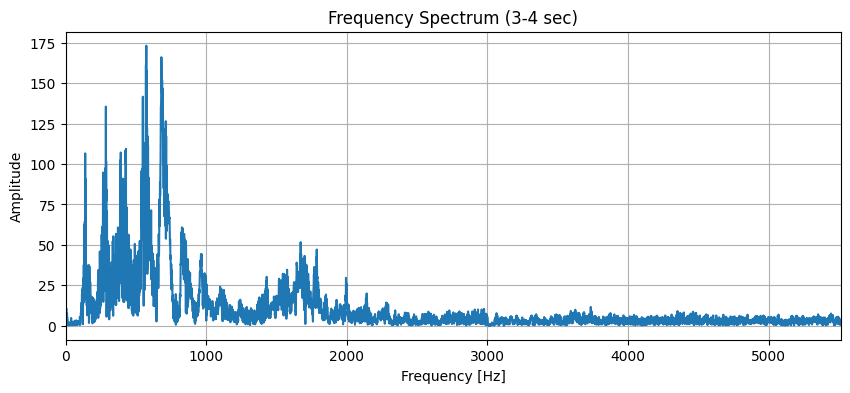

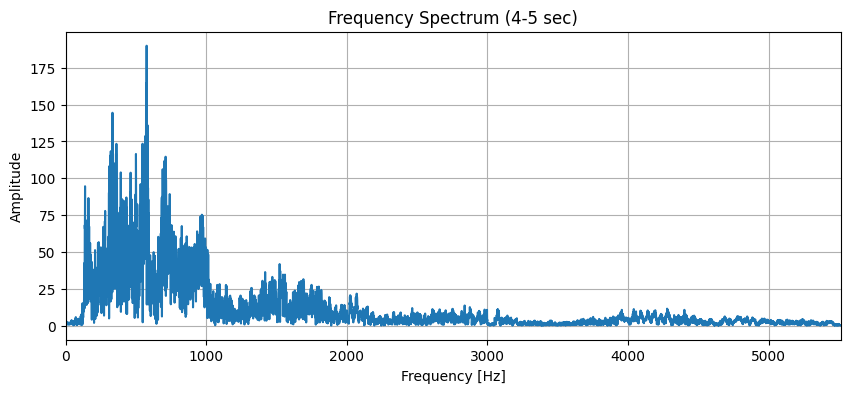

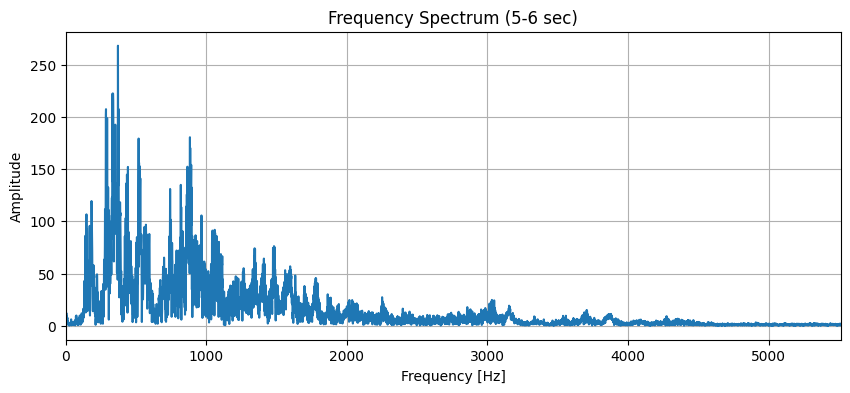

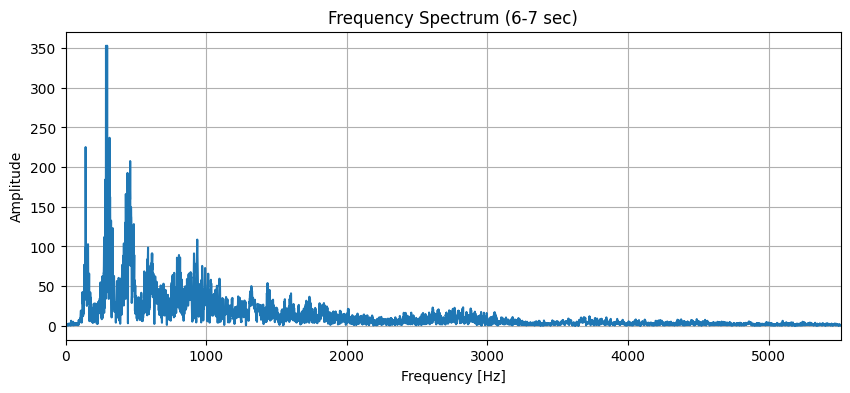

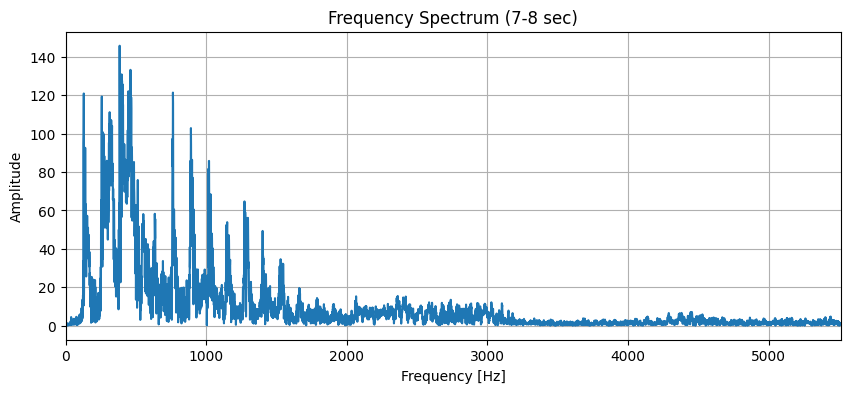

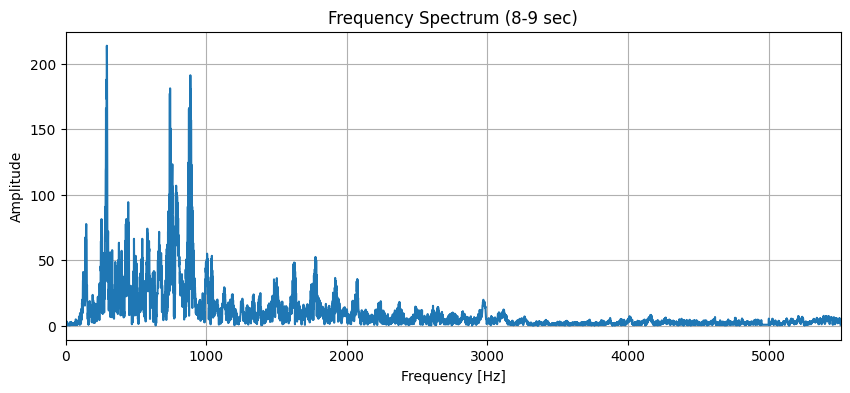

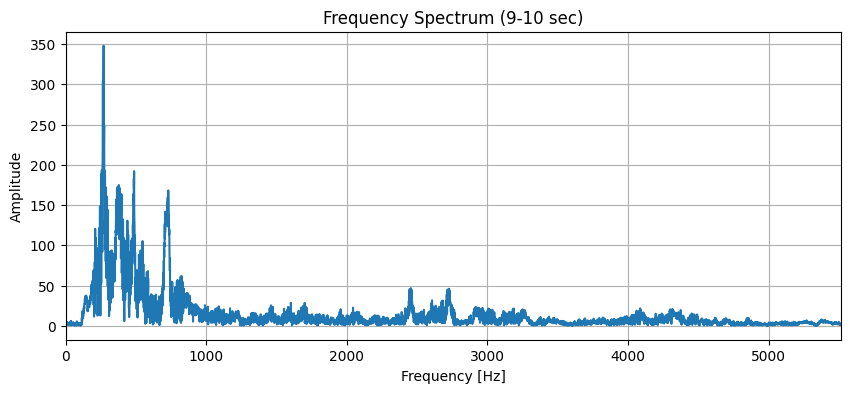

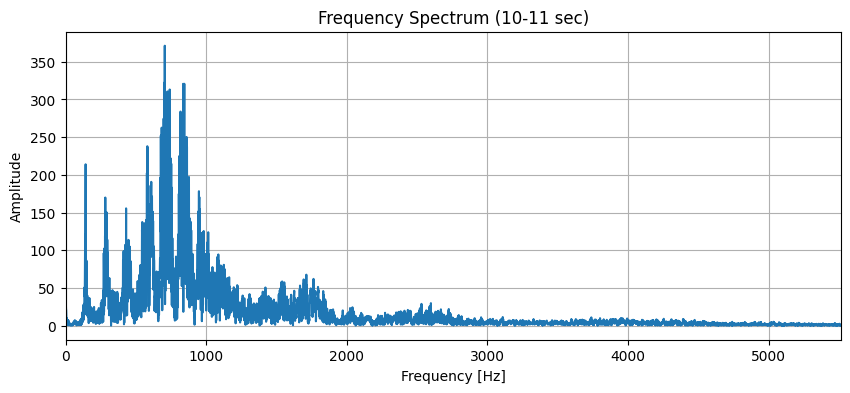

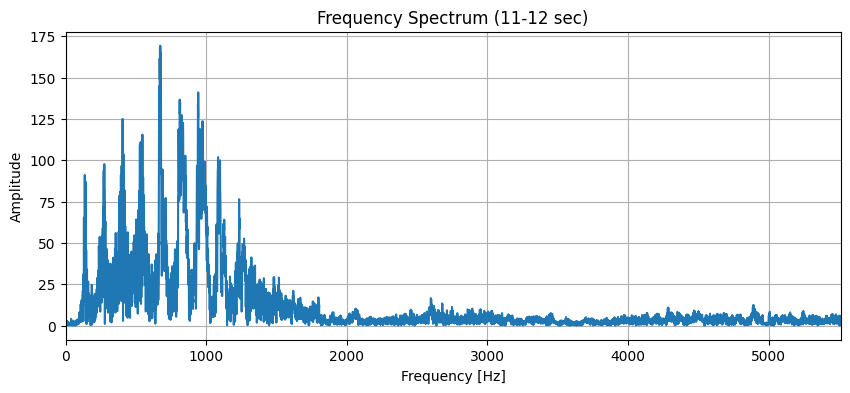

In [ ]:
y = y_clean.astype(float)
total_sec = int(len(y) / sample_rate)  # total duration in seconds

# Loop through each 1-second segment
for start_time in range(total_sec):
    end_time = start_time + 1
    y_cut = y[start_time*sample_rate:end_time*sample_rate]

    # FFT
    N = len(y_cut)
    fft_result = np.fft.fft(y_cut)
    fft_freq = np.fft.fftfreq(N, 1/sample_rate)

    # Only positive frequencies
    pos_mask = fft_freq > 0
    fft_freq_pos = fft_freq[pos_mask]
    fft_mag = np.abs(fft_result[pos_mask]) / N

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(fft_freq_pos, fft_mag)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.title(f'Frequency Spectrum ({start_time}-{end_time} sec)')
    plt.xlim(0, sample_rate/2)
    plt.grid(True)
    plt.show()

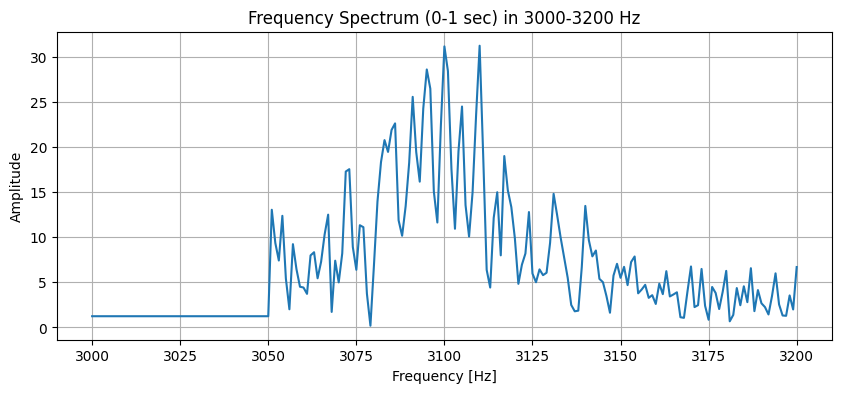

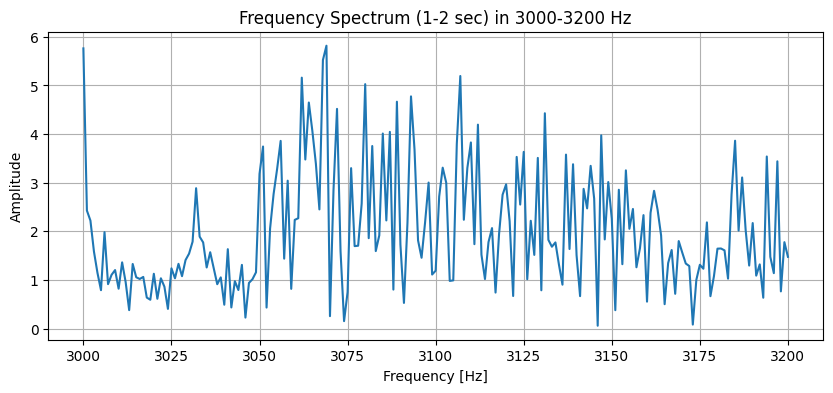

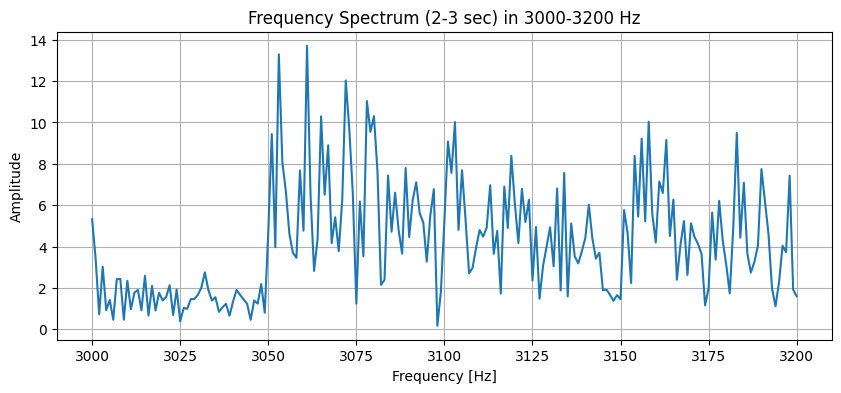

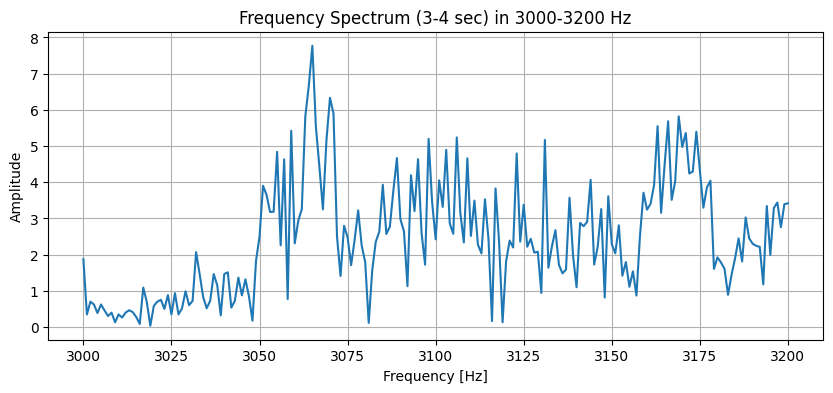

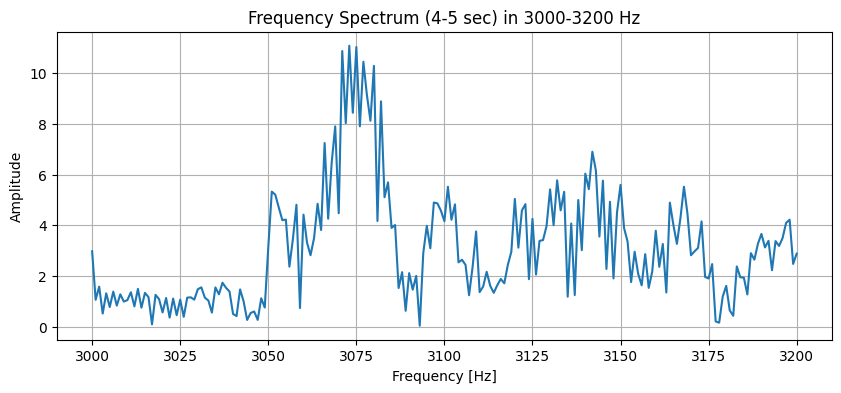

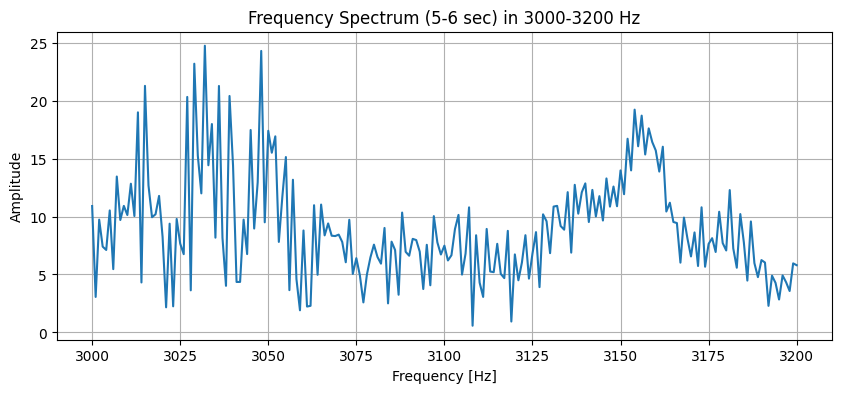

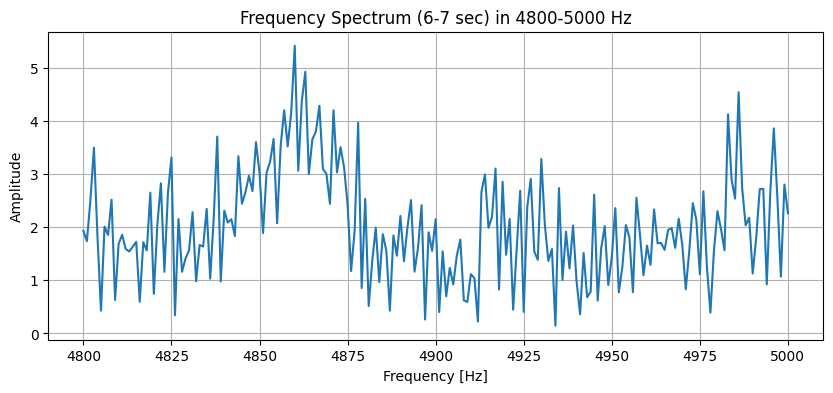

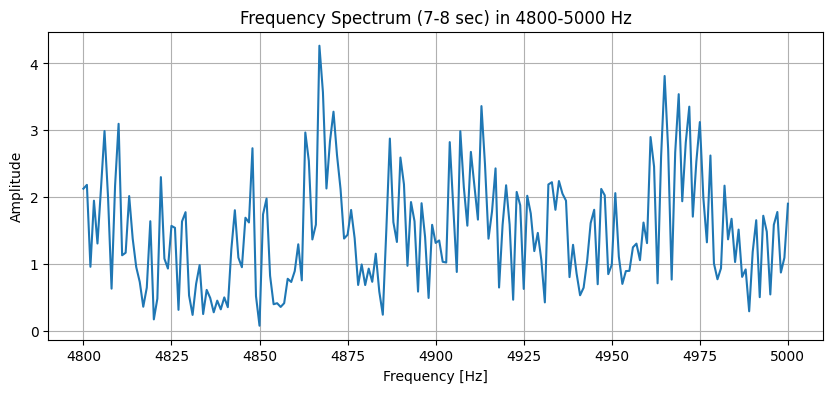

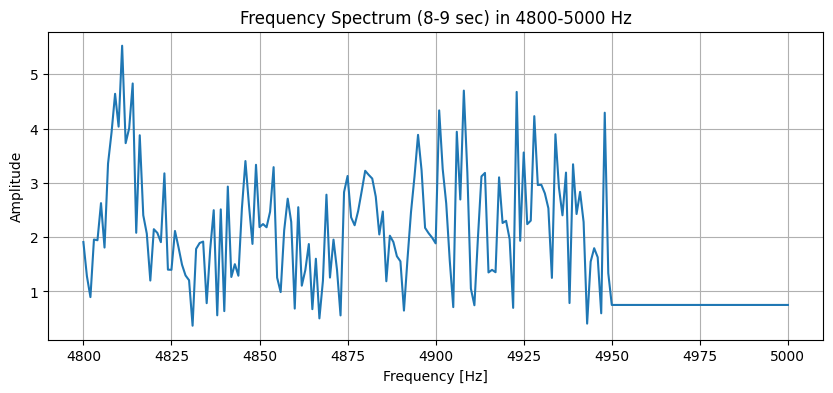

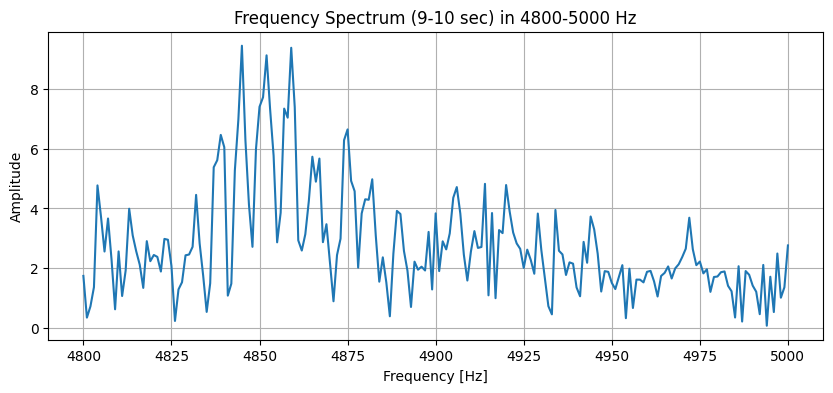

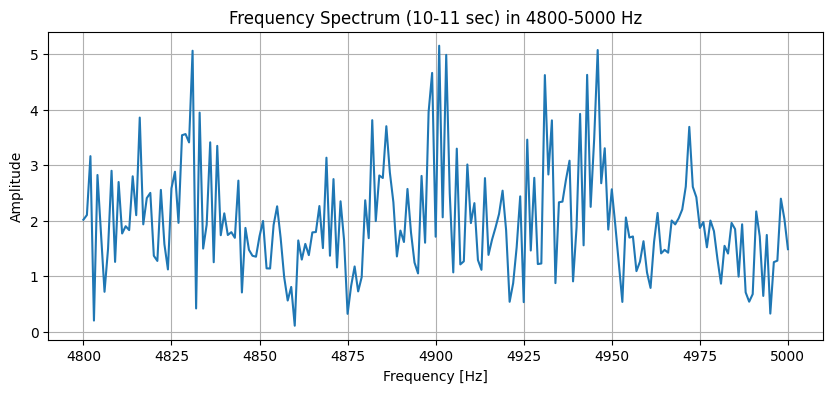

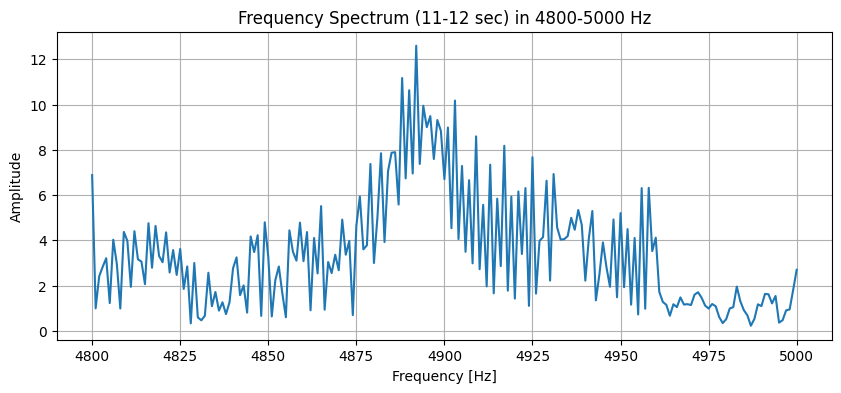

In [ ]:
for start_time in range(total_sec):
    end_time = start_time + 1
    y_cut = y[start_time*sample_rate:end_time*sample_rate]

    # FFT
    N = len(y_cut)
    fft_result = np.fft.fft(y_cut)
    fft_freq = np.fft.fftfreq(N, 1/sample_rate)

    # Only positive frequencies
    pos_mask = fft_freq > 0
    fft_freq_pos = fft_freq[pos_mask]
    fft_mag = np.abs(fft_result[pos_mask]) / N  # normalize

    # Select frequency zone based on start_time
    if start_time < 6:
        f_low, f_high = 3000, 3200
    else:
        f_low, f_high = 4800, 5000

    zone_mask = (fft_freq_pos >= f_low) & (fft_freq_pos <= f_high)
    fft_zone_freq = fft_freq_pos[zone_mask]
    fft_zone_mag = fft_mag[zone_mask]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(fft_zone_freq, fft_zone_mag)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.title(f'Frequency Spectrum ({start_time}-{end_time} sec) in {f_low}-{f_high} Hz')
    plt.grid(True)
    plt.show()

# Check Answer

In [ ]:
import numpy as np
from scipy.io import wavfile

# ===== Utils =====
def to_float(sig):
    if np.issubdtype(sig.dtype, np.integer):
        if sig.dtype == np.int16:
            sig = sig.astype(np.float64) / 32768.0
        elif sig.dtype == np.int32:
            sig = sig.astype(np.float64) / 2147483648.0
        elif sig.dtype == np.uint8:
            sig = (sig.astype(np.float64) - 128.0) / 128.0
        else:
            sig = sig.astype(np.float64) / max(np.max(np.abs(sig)), 1.0)
    else:
        sig = sig.astype(np.float64)
    return sig

def to_mono(x):
    return x.mean(axis=1) if x.ndim > 1 else x

def remove_dc(x):
    return x - np.mean(x)

def rms(x):
    x = np.asarray(x, dtype=np.float64)
    return np.sqrt(np.mean(x**2) + 1e-18)

def rms_match(y, target_rms):
    cur = rms(y)
    if cur == 0:
        return np.zeros_like(y)
    return y * (target_rms / cur)

# ===== Load both files =====
ORIG_PATH = "/content/exercise.wav"
PROC_PATH = "/content/exercise_cleaned.wav"

fs1, x_raw = wavfile.read(ORIG_PATH)
fs2, y_raw = wavfile.read(PROC_PATH)
assert fs1 == fs2, f"Sample rate mismatch: {fs1} vs {fs2}"
fs = fs1

# ===== Normalize & preprocess the SAME WAY =====
x = to_float(x_raw)
y = to_float(y_raw)
x = to_mono(x); y = to_mono(y)
x = remove_dc(x); y = remove_dc(y)          # << สำคัญ: ให้ตรงกับตอนทำฟิลเตอร์

# (ตัวเลือก) ให้ยาวเท่ากัน
n = min(len(x), len(y))
x = x[:n]; y = y[:n]

# (ตัวเลือก) RMS-match เพื่อลดผลจาก gain เล็กน้อยที่ฟิลเตอร์ทำ
y_rm = rms_match(y, rms(x))

# ===== คำนวณ MAE =====
mae_raw = np.mean(np.abs(x - y)) * 100
mae_rms = np.mean(np.abs(x - y_rm)) * 100

print(f"MAE (no RMS-match) = {mae_raw:.6f} %")
print(f"MAE (RMS-matched)  = {mae_rms:.6f} %")

MAE (no RMS-match) = 0.561713 %
MAE (RMS-matched)  = 0.566560 %
